# Assignment 1

## TOC:

* [0. Set up environment](#prep)
* [1. Introduction to assignment 1](#intro)
* [2. Lasso as a benchmark](#lasso)
* [3. Neural networks](#nn)

## 0. Set up environment <a name="prep"></a>
As you know from Homework 0, you need to link your Google Drive and select GPU runtime.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/DS5660/hw1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Introduction to assignment 1 <a name="intro"></a>

In this assignment, you are asked to understand the difference between statistical modeling and deep learning modeling, get familiarized with building simple neural networks model, understand bias-variance tradeoff, and predict the outcome using the best model selected.

First, let's install modules not already installed by Google Colab. 

In [ ]:
! pip install torch_utils

You need to restart runtime here.

In [ ]:
# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf

## 2. Lasso as a benchmark <a name="lasso"></a>





In [ ]:
# import training data set
train_data = pd.read_csv('data/train.csv') # 1022 by 258

# get training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[2:258] ]
train_y = train_data.loc[train_data['index']=="training",'SalePrice']

# get validation set: n = 222
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[2:258] ]
validation_y = train_data.loc[train_data['index']=="validation",'SalePrice']

# run cross-validated lasso
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(train_x, train_y)

# run lasso at best lambda
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_x, train_y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Lasso(alpha=72.35603144189001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=72.35603144189001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
# generate predictions for the validation set
y_out = lasso.predict(validation_x)

# calculate rmse in validation set
'rmse in the validation set: '+str(round(math.sqrt(((validation_y - y_out).pow(2)).mean()),3) ) # 37120

'rmse in the validation set: 37120.641'

Text(0.5, 0, 'Targeted y')

Text(0, 0.5, 'Modeled y')

(100000.0, 600000.0)

(100000.0, 600000.0)

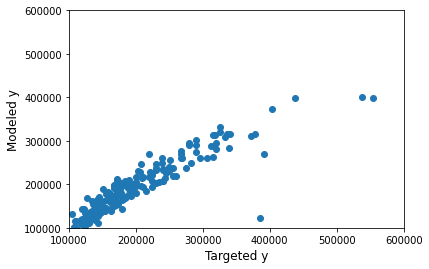

In [ ]:
# plot prediction calibration
plt.plot(validation_y,y_out, 'o')
plt.xlabel('Targeted y', fontsize=12)
plt.ylabel('Modeled y', fontsize=12)
plt.ylim(1e5,6e5)
plt.xlim(1e5,6e5)
plt.show()

## 3. Neural network <a name="nn"></a>

Data preparation

In [ ]:
# import data
train_data = pd.read_csv('data/train.csv') # 1022 by 259
test_data = pd.read_csv('data/prediction.csv') # 438 by 258

df=train_data.drop(["Id",'SalePrice',"index"],axis=1)
#df=train_data

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]


print(to_drop)

['FireplaceQu', 'GarageArea', 'GarageCond', 'PoolQC', 'Neighborhood_Somerst', 'BldgType_2fmCon', 'BldgType_Duplex', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_SLvl', 'RoofStyle_Hip', 'RoofMatl_Tar&Grv', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'CentralAir_Y', 'GarageType_No', 'GarageFinish_No', 'MiscFeature_Gar2', 'MiscFeature_Shed', 'SaleCondition_Partial']


In [ ]:
# Drop features 
train_data.drop(to_drop, axis=1, inplace=True)
test_data.drop(to_drop, axis=1, inplace=True)

print(train_data) 

        Id  SalePrice  ...  SaleCondition_Normal       index
0        1     208500  ...                     1    training
1        2     181500  ...                     1    training
2        3     223500  ...                     1    training
3        4     140000  ...                     0    training
4        5     250000  ...                     1    training
...    ...        ...  ...                   ...         ...
1017  1456     175000  ...                     1    training
1018  1457     210000  ...                     1    training
1019  1458     266500  ...                     1    training
1020  1459     142125  ...                     1    training
1021  1460     147500  ...                     1  validation

[1022 rows x 235 columns]


In [ ]:
to_use = list(range(2,226)) 

# training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[to_use] ]
train_min = train_x.min()
train_max = train_x.max()

train_x = (train_x - train_min) / (train_max - train_min) # make 0-1 transformation
train_x = train_x.fillna(0)

train_X = torch.tensor(train_x.values).float()

train_y = torch.tensor(train_data.loc[train_data['index']=="training",'SalePrice'].values).float().view(-1,1)
train_Y = train_y/1e2 # divide the original price by 100 for better prediction

# validation set
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[to_use] ]

validation_x = (validation_x - train_min) / (train_max - train_min) # use training data to make 0-1 transformation

validation_x = validation_x.fillna(0)
validation_x[validation_x==inf] = 0
validation_X = torch.tensor(validation_x.values).float()

validation_y = torch.tensor(train_data.loc[train_data['index']=="validation",'SalePrice'].values).float().view(-1,1)
validation_Y = validation_y/1e2 # divide the original price by 100 for better prediction

# prediction set
test_x = test_data.iloc[:,[x - 1 for x in to_use]]
test_x = (test_x - train_min) / (train_max - train_min)
test_x = test_x.fillna(0)
test_x[test_x==inf] = 0
test_X = torch.tensor(test_x.values).float()


Define the neural networks model

In [ ]:
device = torch.device("cuda")
# device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,output_d)
        self.dropout1 = nn.Dropout(0.8) 

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.fc2(out)
        return out

# define dimensions
input_d = len(to_use)
hidden_d = 640 
output_d = 1

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_fn = F.mse_loss

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        # generate predictions
        pred = model(inputs)
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return(losses.avg)

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss',math.ceil(validation_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets )

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 50 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss: %.03f" % (best_loss))
    return out_train_loss, out_validate_loss



In [ ]:
out_train_loss, out_validate_loss = fit(1500, model, loss_fn, opt)

[50/1500] training loss: 125425.817, validation loss: 109593.030
[100/1500] training loss: 97572.755, validation loss: 93392.504
[150/1500] training loss: 102095.742, validation loss: 78312.360
[200/1500] training loss: 89891.083, validation loss: 108164.131
[250/1500] training loss: 88101.263, validation loss: 82385.925
[300/1500] training loss: 89672.160, validation loss: 69630.449
[350/1500] training loss: 74932.119, validation loss: 68906.094
[400/1500] training loss: 73576.485, validation loss: 71298.601
[450/1500] training loss: 83234.725, validation loss: 64125.660
[500/1500] training loss: 80340.077, validation loss: 84035.714
[550/1500] training loss: 69612.285, validation loss: 72754.049
[600/1500] training loss: 64322.914, validation loss: 74252.033
[650/1500] training loss: 70597.395, validation loss: 63517.409
[700/1500] training loss: 70272.049, validation loss: 76281.555
[750/1500] training loss: 71772.804, validation loss: 64394.388
[800/1500] training loss: 66657.708, 

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

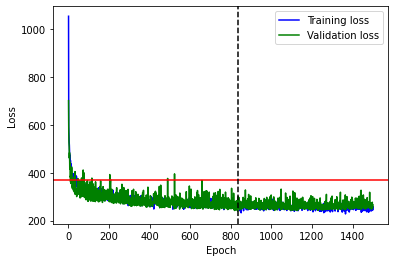

In [ ]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,1501)),  # 改
             'TrainLoss': [math.sqrt(x) for x in out_train_loss],
             'ValidateLoss': [math.sqrt(x) for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
plt.axhline(y=371, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Before calculating rmse and plotting the prediction calibration, you need to restart runtime.

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cuda()) * 1e2

# rmse
math.sqrt(mean_squared_error(validation_y, preds.cpu())) # 29917

<All keys matched successfully>

bmodel(
  (fc1): Linear(in_features=224, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=1, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
)

24055.46923258825

Text(0.5, 0, 'Targeted y')

Text(0, 0.5, 'Modeled y')

(100000.0, 800000.0)

(100000.0, 800000.0)

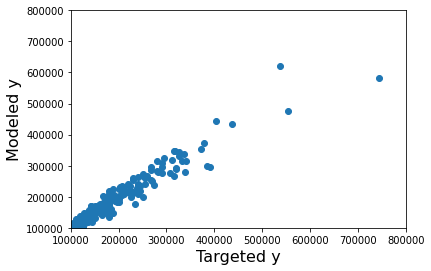

In [ ]:
# calibration plot of the validation set
plt.plot( (validation_y).detach().numpy(), preds.cpu().numpy(), 'o')
plt.xlabel('Targeted y', fontsize=16)
plt.ylabel('Modeled y', fontsize=16)
plt.ylim(1e5,8e5)
plt.xlim(1e5,8e5)
plt.show()


Make prediction in the test set

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X.cuda())*1e2

# output the prediction
out = {'Id': test_data.iloc[:,0],
       'SalePrice': output.squeeze().tolist()}

out_d = pd.DataFrame(out)

out_d.to_csv("data/sample_nn_test.csv",index=False)


bmodel(
  (fc1): Linear(in_features=224, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=1, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
)